# Machine Learning for Nickel Catalyzed Borylation in MeOH

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math as math
import matplotlib.pyplot as plt

import xgboost as xgb
import shap

import pickle

### Load Preprocessed Methanol Dataset

In [2]:
dataset = pd.read_csv("./data/data_MeOH_Final.csv")
dataset.head()

,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Ligand,Ligand_inchi,Product_inchi,Solvent_inchi,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,50.731606,50.731606,351.19888,1.840787,-0.055960,A-paPhos,InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",88.86
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,80.673770,61.935337,479.46484,1.803143,-0.058457,CX-FBu,InChI=1S/C29H39P.BF4/c1-2-3-22-29(27-20-12-10-...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",54.07
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,107.755370,56.694310,386.44120,1.805810,-0.058387,CX-PCy,InChI=1S/C22H30NP/c1-4-11-19(12-5-1)23-18-10-1...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",74.99
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,117.597336,54.091050,618.03375,1.817123,-0.054418,Cy-BippyPhos,InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",82.92
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,111.484024,57.033180,402.37967,1.816461,-0.061351,Cy-JohnPhos,InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",80.25


### Prepare Hold-out Electrophiles Testing Set

In [3]:
dataset.Electrophile.unique().tolist()

['1H-indol-5-yl\xa0N,N-dimethylsulfamate',
 "2-bromo-1,1'-biphenyl",
 '2-Chloro-5-fluorotoluene',
 '2-Chloro-m-xylene',
 '(2-Methyl-1,3-benzothiazol-5-yl)\xa0N,N-dimethylsulfamate',
 '3-Bromothiophene',
 '3-Chloro-2-methylaniline',
 '4-Bromoanisole',
 '4-Bromobenzotrifluoride',
 '4-Chloro-N,N-dimethylbenzamide',
 '5-chloroindole',
 'BMS-929356',
 'Ethyl\xa04-chloro-3-fluorobenzoate',
 'methyl\xa04-bromobenzoate',
 'quinolin-6-yl dimethylsulfamate',
 '3-Bromoquinoline',
 '3-bromo-2-methylpyridine',
 'Clofibrate',
 '4-Bromo-2-fluoroanisole',
 '4-Bromo-2-fluorobenzonitrile',
 '(4-Phenylphenyl) N,N-dimethylsulfamate',
 '4-Bromo-1,2-(methylenedioxy)benzene',
 '5-Bromobenzofuran',
 '4-chloro-1-fluoro-2-methoxybenzene',
 '4-chlorobenzotrifluoride',
 '3-chloroquinoline',
 '5-bromo-2,4-dimethoxypyrimidine',
 'methyl\xa04-chlorobenzoate',
 '5-Chloro-1,3-benzodioxole',
 '4-chloro-2-fluoro-1-methoxybenzene',
 '4-Chloro-2-fluoroanisole',
 '4-Chlorobiphenyl',
 '4-Bromobiphenyl',
 '4-Chloro-2-fluorob

In [4]:
indices=[0,12,17]
mapped = map(dataset.Electrophile.unique().tolist().__getitem__, indices)
external_list=list(mapped)
ML_data_validation = dataset[dataset['Electrophile'].isin(external_list)]
ML_data_validation2 = ML_data_validation.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print (ML_data_validation2.shape)
ML_data_validation2.head()

(69, 157)


,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_qvtot_min_min,Kraken_vbur_qvtot_min_vburminconf,Kraken_vbur_ratio_vbur_vtot_boltz,Kraken_vbur_vbur_boltz,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,59.829678,59.829678,0.144453,50.731606,50.731606,50.731606,351.19888,1.840787,-0.055960,88.86
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,47.895260,67.167030,0.134809,64.636100,80.673770,61.935337,479.46484,1.803143,-0.058457,54.07
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,36.894516,75.417816,0.211005,81.541550,107.755370,56.694310,386.44120,1.805810,-0.058387,74.99
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,45.164505,77.044235,0.160584,99.246600,117.597336,54.091050,618.03375,1.817123,-0.054418,82.92
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,44.561430,72.197180,0.212085,85.339290,111.484024,57.033180,402.37967,1.816461,-0.061351,80.25


In [5]:
#Keep the rest of the dataset for model training purpose
exclude_list = ML_data_validation.index.values.tolist()
ML_data_traintest = dataset[~dataset.index.isin(exclude_list)]
ML_data_traintest2 = ML_data_traintest.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print (ML_data_traintest2.shape)
ML_data_traintest2.head()

(710, 157)


,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_qvtot_min_min,Kraken_vbur_qvtot_min_vburminconf,Kraken_vbur_ratio_vbur_vtot_boltz,Kraken_vbur_vbur_boltz,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Yield
23,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,59.829678,59.829678,0.144453,50.731606,50.731606,50.731606,351.19888,1.840787,-0.055960,48.175
24,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,47.895260,67.167030,0.134809,64.636100,80.673770,61.935337,479.46484,1.803143,-0.058457,22.925
25,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,36.894516,75.417816,0.211005,81.541550,107.755370,56.694310,386.44120,1.805810,-0.058387,70.335
26,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,45.164505,77.044235,0.160584,99.246600,117.597336,54.091050,618.03375,1.817123,-0.054418,73.775
27,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,44.561430,72.197180,0.212085,85.339290,111.484024,57.033180,402.37967,1.816461,-0.061351,55.420


In [6]:
X_train=ML_data_traintest2.drop(columns=['Yield'])
Y_train=ML_data_traintest2['Yield']

### XGBOOST

In [7]:
%%time

rng = np.random.RandomState(0)
steps = [('scaler', StandardScaler()),
        ('XGB', xgb.XGBRegressor(random_state=rng))] #when subsample is used
pipeline = Pipeline(steps)
parameters = {"XGB__n_estimators": [50, 100, 250, 1000],
              "XGB__learning_rate": [0.01, 0.05, 0.1],
              "XGB__max_depth": [6],
              "XGB__colsample_bytree": [0.7],
              "XGB__min_child_weight": [5, 15],
              "XGB__subsample": [0.5]}

XGB_cv = GridSearchCV(pipeline, param_grid = parameters, cv = 5)
XGB_cv.fit(X_train, Y_train)

CPU times: user 2h 31min 11s, sys: 7min 33s, total: 2h 38min 44s
Wall time: 39min 44s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('XGB',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     enable_categorical=False,
                                                     gamma=None, gpu_id=None,
                                                     importance_type=None,
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                     

In [8]:
XGB_cv.best_params_

{'XGB__colsample_bytree': 0.7,
 'XGB__learning_rate': 0.01,
 'XGB__max_depth': 6,
 'XGB__min_child_weight': 15,
 'XGB__n_estimators': 1000,
 'XGB__subsample': 0.5}

In [9]:
XGB_cv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('XGB',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=6,
                              min_child_weight=15, missing=nan,
                              monotone_constraints='()', n_estimators=1000,
                              n_jobs=32, num_parallel_tree=1, predictor='auto',
                              random_state=209652396, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.5,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

### Hold-out Electrophiles Testing set Evaluation

In [10]:
ext_y=ML_data_validation2['Yield']
ext_X=ML_data_validation2.iloc[:, ML_data_validation2.columns.isin(X_train.columns)]
XGB_Y_Pred = XGB_cv.best_estimator_.predict(ext_X)

In [11]:
r2_score(ext_y,XGB_Y_Pred) 

0.23317432772041935

In [12]:
mse = mean_squared_error(ext_y, XGB_Y_Pred)
print(math.sqrt(mse))

22.555931269637373


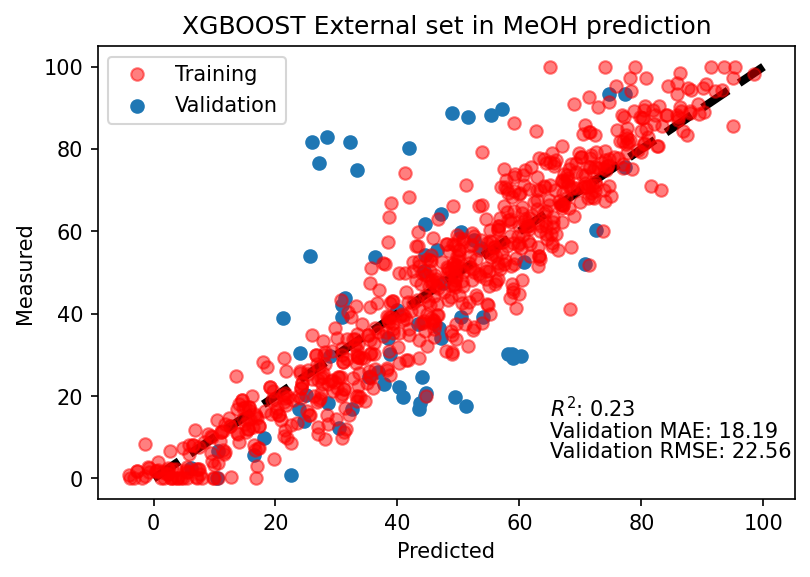

In [13]:
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
ax.scatter(XGB_Y_Pred,ext_y,label="Validation")
ax.plot( [0,100],[0,100], 'k--', lw=4)
ax.plot(XGB_cv.predict(X_train), Y_train, "or", alpha=0.5, label="Training")
ax.text(65,15,r'$R^2$: {:0.2f}'.format(r2_score(ext_y,XGB_Y_Pred)))    #make sure actual first predict next!
ax.text(65,10,'Validation MAE: {:0.2f}'.format(mean_absolute_error(ext_y,XGB_Y_Pred)))
ax.text(65,5,'Validation RMSE: {:0.2f}'.format(np.sqrt(mean_squared_error(ext_y,XGB_Y_Pred))))
ax.set_xlabel('Predicted')
ax.set_ylabel('Measured')
ax.set_title('XGBOOST External set in MeOH prediction')
plt.legend()
plt.show()

<AxesSubplot:ylabel='feature'>

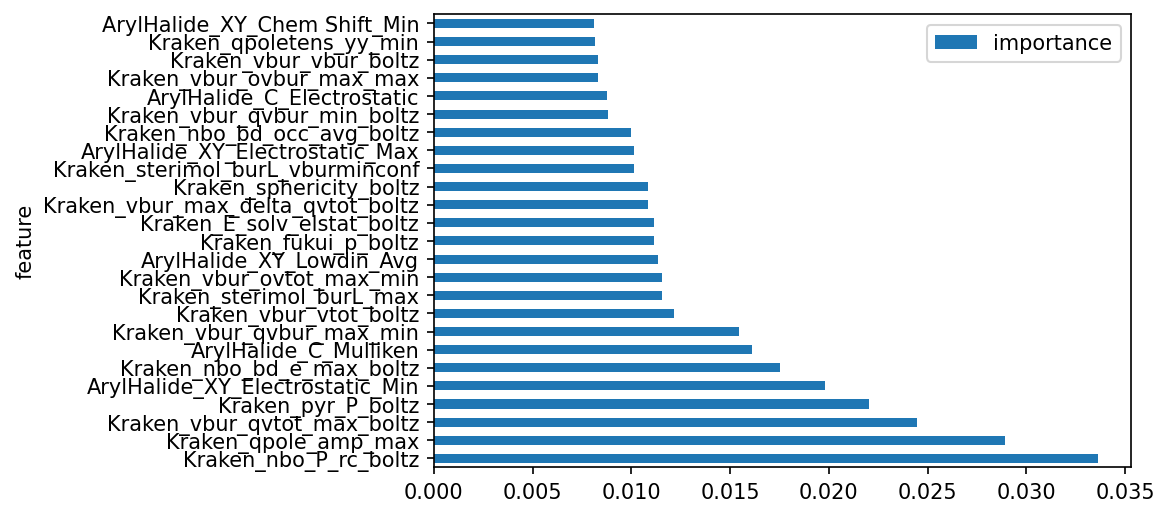

In [14]:
feature_important = XGB_cv.best_estimator_.named_steps["XGB"].get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
df = df.head(50)
sorted_idx = XGB_cv.best_estimator_.named_steps["XGB"].feature_importances_.argsort()
df=pd.DataFrame(list(zip(X_train.columns[sorted_idx], 
                      XGB_cv.best_estimator_.named_steps["XGB"].feature_importances_[sorted_idx])))
df2 = df.sort_values(by=[1], ascending=False).head(25)
df2.columns = ['feature', 'importance']
df2.set_index('feature',inplace=True)
df2.plot(kind='barh')

### Shap explainer

In [15]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(XGB_cv.best_estimator_.named_steps["XGB"])
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


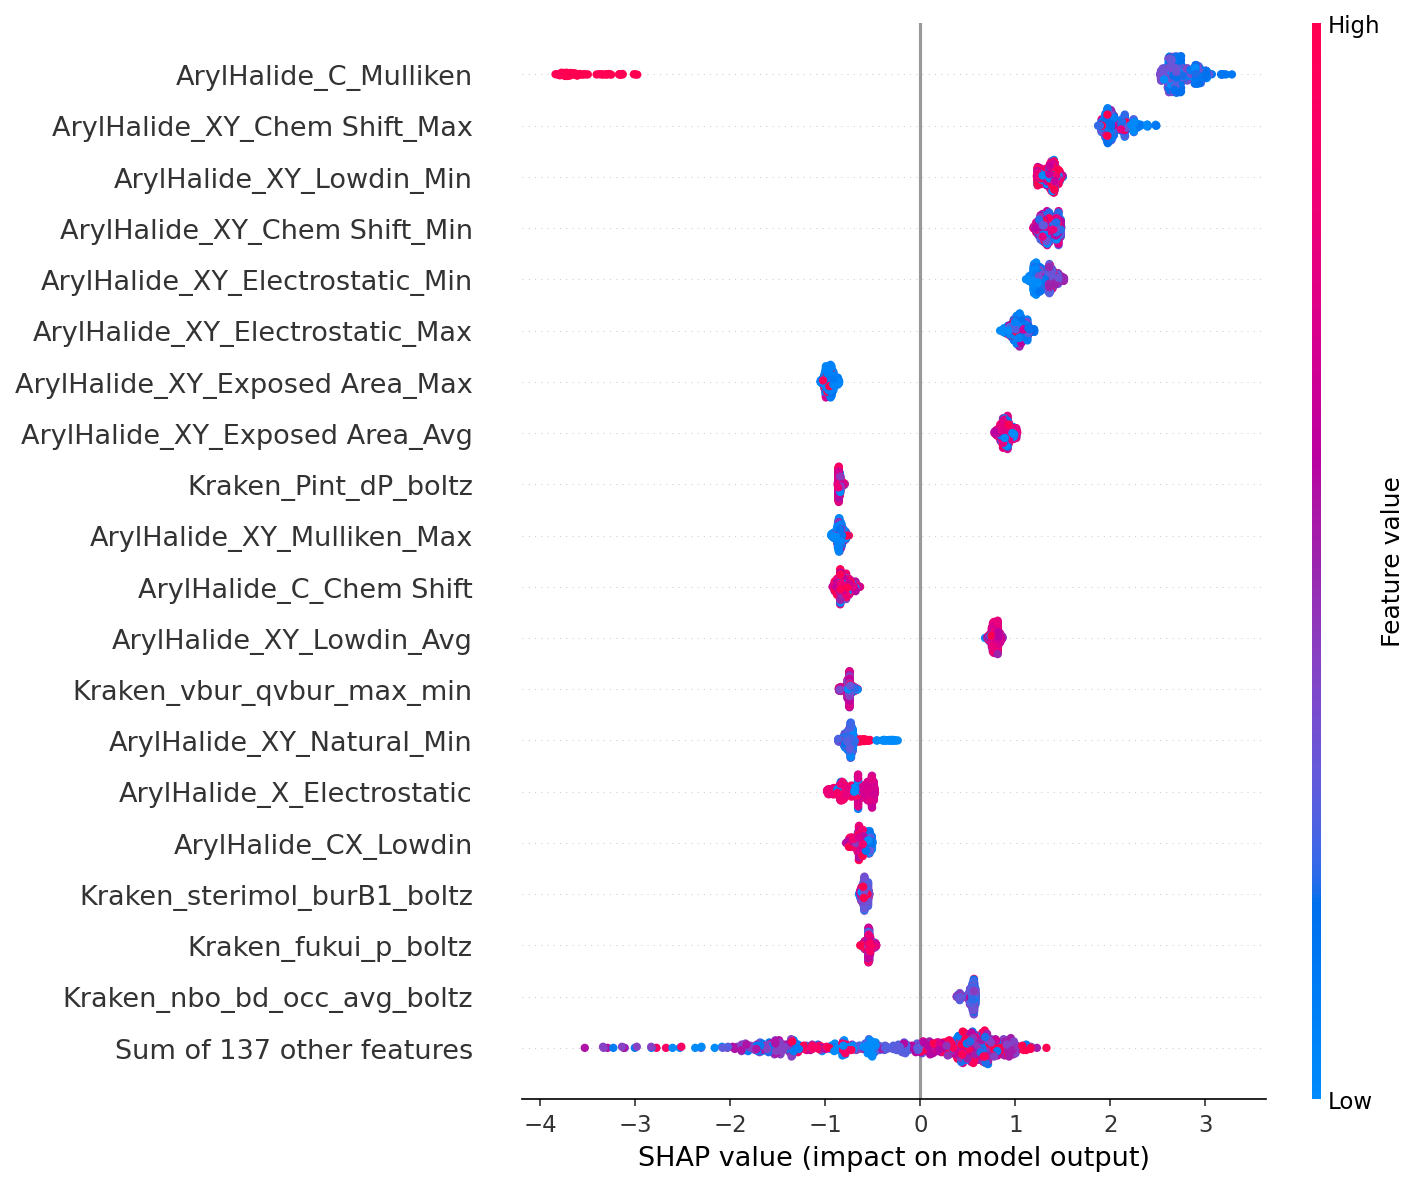

In [16]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=20)

In [17]:
%load_ext watermark

In [18]:
%watermark --iversions

shap      : 0.40.0
matplotlib: 3.3.3
pandas    : 1.2.0
xgboost   : 1.5.1
numpy     : 1.19.2

